In [1]:
import pprint
import time

import zmq
from sympy.physics.units import current

ctx = zmq.Context()
# The REQ talks to Pupil remote and receives the session unique IPC SUB PORT
socket = ctx.socket(zmq.REQ)

ip = 'localhost'
port = 50020

socket.connect(f'tcp://{ip}:{port}')

# Request 'SUB_PORT' for reading data
socket.send_string('SUB_PORT')
sub_port = socket.recv_string()

# Request 'PUB_PORT' for writing data
socket.send_string('PUB_PORT')
pub_port = socket.recv_string()

socket.close()

In [2]:
import cv2
import msgpack
import pprint
import matplotlib.pyplot as plt

import numpy as np


def create_socket(ctx_c, ip_c, topics):
    sub = ctx_c.socket(zmq.SUB)
    sub.connect(f'tcp://{ip_c}:{sub_port}')
    for topic in topics:
        sub.subscribe(topic)
    return sub

def receive_gaze_data(n):
    gaze_socket = create_socket(ctx, ip, ['gaze.'])
    gaze_data = []
    for i in range(n):
        topic, payload = gaze_socket.recv_multipart()
        message = msgpack.loads(payload)
        gaze_data.append(message)
    return gaze_data

def receive_fixation_data(n):
    fixation_socket = create_socket(ctx, ip, ['fixation'])
    data = []
    for i in range(n):
        topic, payload = fixation_socket.recv_multipart()
        message = msgpack.loads(payload)
        data.append(message)
    fixation_socket.close()
    return data

def receive_frame(n):
    socket_frame = create_socket(ctx, ip, ['frame.world'])
    frames = []
    for i in range(n):
        frame = socket_frame.recv_multipart()
        frames.append(frame)
    socket_frame.close()
    return frames

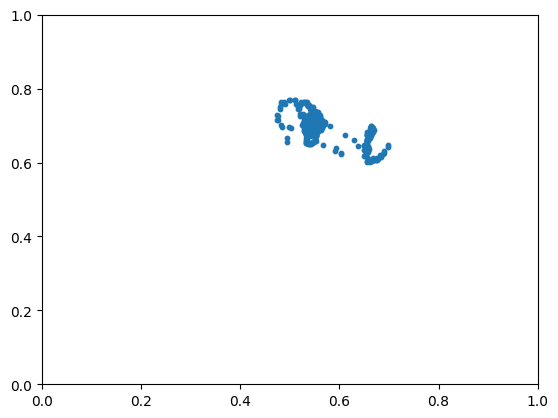

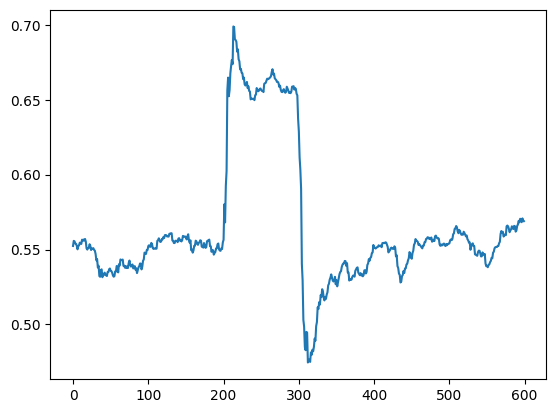

In [4]:

fixation_data = receive_fixation_data(5)
fixation_pos_arr = np.array([data['norm_pos'] for data in fixation_data])
origin = np.mean(fixation_pos_arr, axis=0)

frame = receive_frame(1)[0]

gaze_data = receive_gaze_data(600)

# Plot the gaze points
gaze_norm_pos = np.array([data['norm_pos'] for data in gaze_data])
plt.scatter(gaze_norm_pos[:, 0], gaze_norm_pos[:, 1], s=10)
plt.xlim(0, 1)

plt.ylim(0, 1)
plt.show()

# Plot the x  coordinate of the gaze points
plt.plot(gaze_norm_pos[:, 0])
plt.show()



In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = cv2.imdecode(np.frombuffer(frame[2], dtype=np.uint8), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
model = YOLO("../.local/models/object_detection/yolov11n_trained.pt", verbose=False)
results = model.predict(img)

img = results[0].plot(pil=True)
img = np.array(img)
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


l1 = [origin[0] - 2, origin[1] + 2]
l2 = [origin[0] - 2, origin[1] - 2]
r1 = [origin[0] + 2, origin[1] + 2]
r2 = [origin[0] + 2, origin[1] - 2]

# plot lines between the origin and l1, l2 on the frame
# compute the image coordinates of the origin
origin_img = (int(origin[0] * img.shape[1]), int(origin[1] * img.shape[0]))

# compute the image coordinates of l1, l2, r1, r2
l1_img = (int(l1[0] * img.shape[1]), int(l1[1] * img.shape[0]))
l2_img = (int(l2[0] * img.shape[1]), int(l2[1] * img.shape[0]))
r1_img = (int(r1[0] * img.shape[1]), int(r1[1] * img.shape[0]))
r2_img = (int(r2[0] * img.shape[1]), int(r2[1] * img.shape[0]))

# plot the lines
cv2.line(img, origin_img, l1_img, (255, 0, 0), 2)
cv2.line(img, origin_img, l2_img, (255, 0, 0), 2)
cv2.line(img, origin_img, r1_img, (255, 0, 0), 2)
cv2.line(img, origin_img, r2_img, (255, 0, 0), 2)

# plot the gaze points
gaze_norm_pos = np.array([[data['norm_pos'][0], 1 - data['norm_pos'][1]] for data in gaze_data])

# clip the gaze points to the screen
gaze_norm_pos = np.clip(gaze_norm_pos, 0.2, 0.8)

gaze_img_pos = (gaze_norm_pos * np.array([img.shape[1], img.shape[0]])).astype(int)
for pos in gaze_img_pos:
    # plot the gaze points and make the color map over time
    cv2.circle(img, tuple(pos), 2, (0, 0, 255), -1)

# load the image with numpy and show it
plt.imshow(np.array(img))



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

l1 = [origin[0] - 2, origin[1] + 2]
l2 = [origin[0] - 2, origin[1] - 2]
r1 = [origin[0] + 2, origin[1] + 2]
r2 = [origin[0] + 2, origin[1] - 2]

# check if the fixation point is in one of the areas seperated by the vectors passing the origin and the corners of the screen
def is_point_in_triangle(p1, p2, p3, p):
    def sign(a, b, c):
        return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    b1 = sign(p, p1, p2) < 0.0
    b2 = sign(p, p2, p3) < 0.0
    b3 = sign(p, p3, p1) < 0.0

    return ((b1 == b2) and (b2 == b3))



gaze_norm_pos = np.array([data['norm_pos'] for data in gaze_data])
avg_gaze = gaze_norm_pos.mean(axis=0)
print(is_point_in_triangle(l2, l1, origin, avg_gaze))

# use colormap to show the order of the gaze points
plt.scatter(gaze_norm_pos[:, 0], gaze_norm_pos[:, 1], s=10, c=np.arange(len(gaze_norm_pos))/120, cmap='viridis')
# plot lines from the origin to the corners of the screen
plt.plot([origin[0], l1[0]], [origin[1], l1[1]], color='r')
plt.plot([origin[0], l2[0]], [origin[1], l2[1]], color='r')
plt.plot([origin[0], r1[0]], [origin[1], r1[1]], color='r')
plt.plot([origin[0], r2[0]], [origin[1], r2[1]], color='r')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()

In [ ]:


def plot_results(data):
    gaze_n = []
    pupil_0_diameter, pupil_1_diameter = [], []
    for d in data:
        gaze_n.append(d['norm_pos'])
        base_data = d['base_data']
        if len(base_data) == 2:
            if base_data[0]['id'] == 0:
                pupil_0_diameter.append(base_data[0]['diameter'])
                pupil_1_diameter.append(base_data[1]['diameter'])
            else:
                pupil_0_diameter.append(base_data[1]['diameter'])
                pupil_1_diameter.append(base_data[0]['diameter'])
        else:
            print('Error: base_data length is not 2')
            pupil_0_diameter.append(np.nan)
            pupil_1_diameter.append(np.nan)

    # create a fig with 4 subplots below each other and size 10x5
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))

    gaze_n = np.array(gaze_n)

    # plot the pupil diameters
    axs[0].plot(pupil_0_diameter, label='Pupil 0', color='r')
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel('diameter [mm]')
    axs[0].set_ylim(20, 40)

    axs[1].plot(pupil_1_diameter, label='Pupil 1', color='b')
    axs[1].set_xlabel('time [s]')
    axs[1].set_ylabel('diameter [mm]')
    axs[1].set_ylim(20, 40)

    axs[2].plot(gaze_n[:, 0], label='Position X', color='g')
    axs[2].set_xlabel('time [s]')
    axs[2].set_ylabel('norm_pos X')
    axs[2].set_ylim(-0.5, 1.5)

    axs[3].plot(gaze_n[:, 1], label='Position Y', color='m')
    axs[3].set_xlabel('time [s]')
    axs[3].set_ylabel('norm_pos Y')
    axs[3].set_ylim(-0.5, 1.5)

    fig.legend()
    fig.tight_layout()
    plt.show()


In [3]:
gaze_data = receive_gaze_data(600)
plot_results(gaze_data)



NameError: name 'plot_results' is not defined

In [4]:
import pprint

fixation_data = receive_fixation_data(5)

pprint.pprint(fixation_data[0])

ids = [data['id'] for data in fixation_data]
print(ids)

{'base_data': [['gaze.3d.01.', 11502.096931],
               ['gaze.3d.01.', 11502.1009655],
               ['gaze.3d.1.', 11502.10154],
               ['gaze.3d.1.', 11502.109609],
               ['gaze.3d.01.', 11502.177621499999],
               ['gaze.3d.01.', 11502.181656],
               ['gaze.3d.01.', 11502.1856905],
               ['gaze.3d.01.', 11502.197794],
               ['gaze.3d.01.', 11502.205863],
               ['gaze.3d.01.', 11502.2179665],
               ['gaze.3d.01.', 11502.23007],
               ['gaze.3d.01.', 11502.242173499999],
               ['gaze.3d.01.', 11502.2502425],
               ['gaze.3d.01.', 11502.258312],
               ['gaze.3d.01.', 11502.2623465],
               ['gaze.3d.01.', 11502.266381],
               ['gaze.3d.01.', 11502.2704155],
               ['gaze.3d.01.', 11502.27445],
               ['gaze.3d.01.', 11502.2784845],
               ['gaze.3d.01.', 11502.282519],
               ['gaze.3d.01.', 11502.2865535],
               ['ga

In [5]:
gaze_data = receive_gaze_data(600)

pprint.pprint(gaze_data[0])


{'base_data': [{'circle_3d': {'center': [-6.235161865009831,
                                         0.3156730916946091,
                                         43.33272929036513],
                              'normal': [-0.2581572530127746,
                                         0.31809857564092103,
                                         -0.9122324971695076],
                              'radius': 1.8214922450842659},
                'confidence': 0.9844297920631817,
                'diameter': 26.727531774032983,
                'diameter_3d': 3.6429844901685318,
                'ellipse': {'angle': 138.7787501521276,
                            'axes': [23.77029227115752, 26.727531774032983],
                            'center': [47.56025265722312, 96.19891646571384]},
                'id': 0,
                'location': [47.56025265722312, 96.19891646571384],
                'method': 'pye3d 0.3.2 real-time',
                'model_confidence': 1.0,
                'norm_p

0.6729250678386933 1.0
0.004177649728568309
1.37505305474414e-05 0.11369012738848511


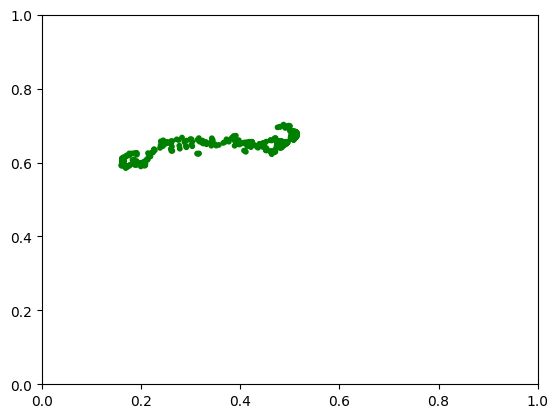

In [6]:
confidence = [data['confidence'] for data in gaze_data if data['confidence'] > 0.6]
gaze_norm_pos = np.array([data['norm_pos'] for data in gaze_data if data['confidence'] > 0.6])
print(min(confidence), max(confidence))
colors = ['r' if c < 0.6 else 'g' for c in confidence]

# comput the distance between the sequence of gaze points
distances = []
for i in range(1, len(gaze_norm_pos)):
    distances.append(np.linalg.norm(gaze_norm_pos[i] - gaze_norm_pos[i - 1]))

print(np.array(distances).mean())
print(min(distances), max(distances))

plt.scatter(gaze_norm_pos[:, 0], gaze_norm_pos[:, 1], s=10, c=colors)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

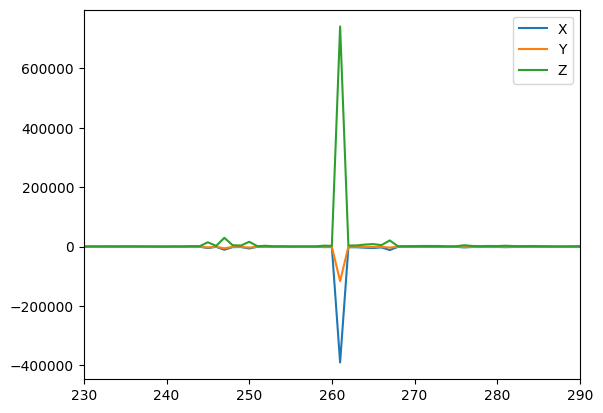

In [8]:
pos_3d = np.array([data['gaze_point_3d'] for data in gaze_data])

plt.plot(pos_3d[:, 0], label='X')
plt.plot(pos_3d[:, 1], label='Y')
plt.plot(pos_3d[:, 2], label='Z')
plt.legend()
plt.xlim(230, 290)
plt.show()